In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, lambda_val=0.4, window_size=20*96):
    """
    计算理想振幅因子 V(λ) = V_high(λ) - V_low(λ)
    
    步骤:
    1. 计算每根K线的振幅: (high/low) - 1
    2. 滚动窗口计算(窗口大小=20天=20*96根15分钟线)
    3. 在每个窗口内:
        - 按收盘价排序
        - 取高价区(收盘价最高的前λ比例)
        - 取低价区(收盘价最低的前λ比例)
        - 分别计算高价区和低价区的振幅均值
    4. 理想振幅因子 = 高价区振幅均值 - 低价区振幅均值
    
    参数:
    df: 包含OHLCV数据的DataFrame
    lambda_val: 切割比例(默认0.4)
    window_size: 滚动窗口大小(默认20天=1920根15分钟线)
    """
    # 计算每根K线的振幅
    amplitude = (df['high'] / df['low']) - 1
    
    # 初始化结果Series
    ideal_amp = pd.Series(index=df.index, dtype=float)
    
    # 滚动窗口计算
    for i in range(window_size, len(df)):
        window_data = df.iloc[i-window_size:i]
        
        # 计算当前窗口的振幅
        window_amp = amplitude.iloc[i-window_size:i]
        
        # 按收盘价排序
        sorted_indices = window_data['close'].argsort()
        sorted_amp = window_amp.iloc[sorted_indices]
        
        # 确定切割位置
        n = len(window_data)
        n_low = int(n * lambda_val)
        n_high = int(n * lambda_val)
        
        # 计算低价区振幅均值
        low_amp_mean = sorted_amp.iloc[:n_low].mean()
        
        # 计算高价区振幅均值
        high_amp_mean = sorted_amp.iloc[-n_high:].mean()
        
        # 计算理想振幅因子
        ideal_amp.iloc[i] = high_amp_mean - low_amp_mean
    
    return ideal_amp

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.000110
   Rank_IC (Spearman): 0.007549
📊 信息比率:
   IR: 0.121173
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 129115
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


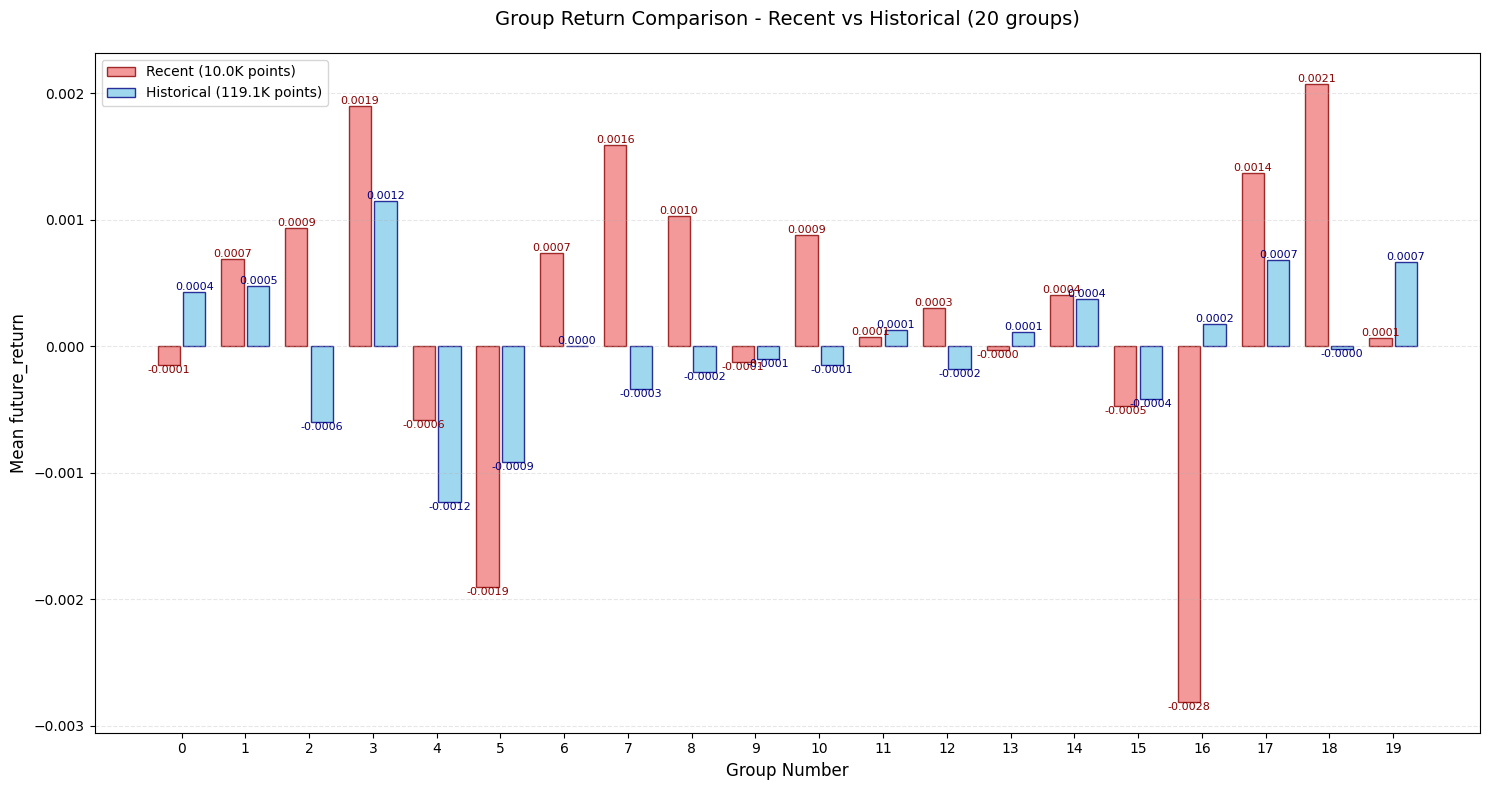

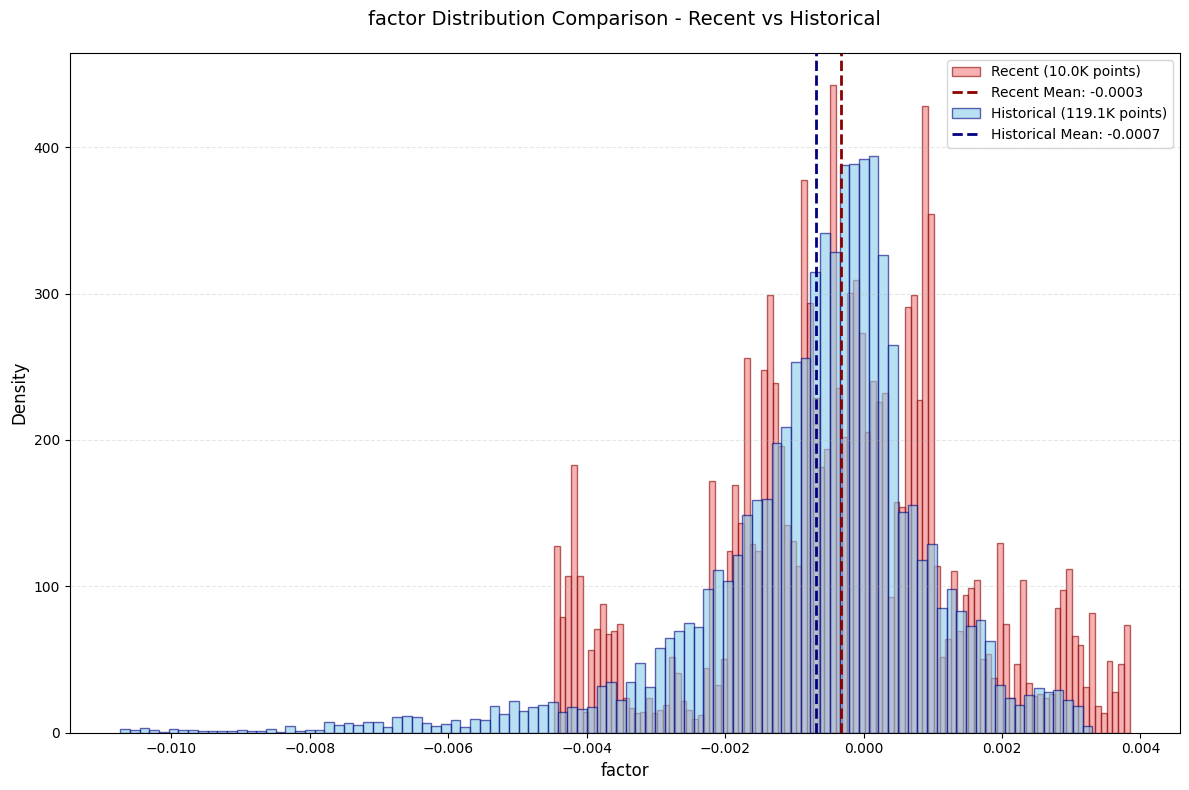

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

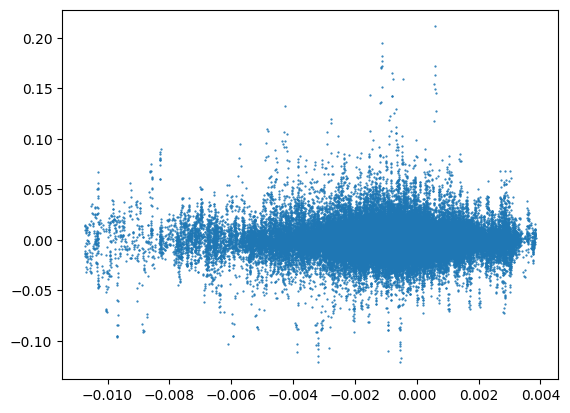

In [6]:
import matplotlib.pyplot as plt
plt.scatter(factor(df),df['close'].pct_change(-10), s=0.3)

In [7]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[-0.009136637569289358,
 0.03478904764353452,
 0.003635509860140105,
 0.0029774462037822427,
 -0.020744547625275514,
 0.019739025514719927,
 0.016414031172858504,
 -0.03088950203882929,
 -0.004589272103931578,
 0.010263935488607673]

In [8]:
print(result)

{'correlation_analysis': {'IC': 0.00011016497901834969, 'Rank_IC': 0.007549081066235444}, 'information_ratio': {'IR': 0.1211728607809155, 'group_correlations': [-0.009136637569289358, 0.03478904764353452, 0.003635509860140105, 0.0029774462037822427, -0.020744547625275514, 0.019739025514719927, 0.016414031172858504, -0.03088950203882929, -0.004589272103931578, 0.010263935488607673], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -0.0107  -0.0039   -0.0057       0.0005      0.0184   6456
1      -0.0039  -0.0027   -0.0032       0.0004      0.0156   6456
2      -0.0027  -0.0021   -0.0023      -0.0005      0.0136   6456
3      -0.0021  -0.0017   -0.0018       0.0011      0.0131   6455
4      -0.0017  -0.0013   -0.0015      -0.0011      0.0125   6456
5      -0.0013  -0.0011   -0.0012      -0.0010      0.0130   6456
6      -0.0011  -0.0009   -0.0010   